## Курсовой проект для курса "Python для Data Science"

### Задача

Материалы к проекту (файлы):
train.csv
test.csv

Задание:
Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

Целевая переменная:
Price

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).
В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

Сроки и условия сдачи:
Дедлайн: сдать проект нужно в течение 72 часов после начала Урока 10 ("Вебинар. Консультация по итоговому проекту").
Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.
При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.
Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.
Успешный проект нельзя пересдать в целях повышения результата.
Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.
В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию,
но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров.
10. Допускается применение библиотек Python и моделей машинного обучения,
которые были в курсе Python для Data Science. Градиентный бустинг изучается
в последующих курсах, поэтому в этом проекте его применять не следует.
Самая сложная из допустимых моделей - RandomForestRegressor из sklearn.

### Подключение библиотек и скриптов

In [266]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели
import random

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score, RandomizedSearchCV

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from scipy.stats import norm
from scipy import stats

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

### Пути к директориям и файлам

In [267]:
TEST_DATASET_PATH = 'test.csv'
TRAIN_DATASET_PATH = 'train.csv'

## Загрузка данных

**Описание датасета**

**Id** - идентификационный номер квартиры,

**DistrictId** - идентификационный номер района,

**Rooms** - количество комнат,

**Square** - площадь,

**LifeSquare** - жилая площадь,

**KitchenSquare** - площадь кухни,

**Floor** - этаж,

**HouseFloor** - количество этажей в доме,

**HouseYear** - год постройки дома,

**Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности,

**Social_1, Social_2, Social_3** - социальные показатели местности,

**Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья,

**Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров,

**Price** - цена квартиры.

In [268]:
train = pd.read_csv(TRAIN_DATASET_PATH)
train.head()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  14038          35    2.0  47.981561   29.442751            6.0      7   
1  15053          41    3.0  65.683640   40.049543            8.0      7   
2   4765          53    2.0  44.947953   29.197612            0.0      8   
3   5809          58    2.0  53.352981   52.731512            9.0      8   
4  10783          99    1.0  39.649192   23.776169            7.0     11   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0         9.0       1969   0.089040         B         B        33      7976   
1         9.0       1978   0.000070         B         B        46     10309   
2        12.0       1968   0.049637         B         B        34      7759   
3        17.0       1977   0.437885         B         B        23      5735   
4        12.0       1976   0.012339         B         B        35      5776   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2          Price  
0         5           NaN            0       11       B  184966.930730  
1         1         240.0            1       16       B  300009.450063  
2         0         229.0            1        3       B  220925.908524  
3         3        1084.0            0        5       B  175616.227217  
4         1        2078.0            2        4       B  150226.531644

In [269]:
test = pd.read_csv(TEST_DATASET_PATH)
test.head()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0    725          58    2.0  49.882643   33.432782            6.0      6   
1  15856          74    2.0  69.263183         NaN            1.0      6   
2   5480         190    1.0  13.597819   15.948246           12.0      2   
3  15664          47    2.0  73.046609   51.940842            9.0     22   
4  14275          27    1.0  47.527111   43.387569            1.0     17   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0        14.0       1972   0.310199         B         B        11      2748   
1         1.0       1977   0.075779         B         B         6      1437   
2         5.0       1909   0.000000         B         B        30      7538   
3        22.0       2007   0.101872         B         B        23      4583   
4        17.0       2017   0.072158         B         B         2       629   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
0         1           NaN            0        0       B  
1         3           NaN            0        2       B  
2        87        4702.0            5        5       B  
3         3           NaN            3        3       B  
4         1           NaN            0        0       A

In [270]:
train.shape[1]

20

In [271]:
train.shape[1] - 1 == test.shape[1]

True

## Приведение типов

In [272]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Датасет содержит три категориальных признака (Ecology_2, Ecology_3, Shops_2). По двум признакам есть пропущенные значения (LifeSquare, Healthcare_1).

Сперва избавимся от категориальных признаков.

In [273]:
obj_features = train.select_dtypes(include='object').columns
obj_features

Index(['Ecology_2', 'Ecology_3', 'Shops_2'], dtype='object')

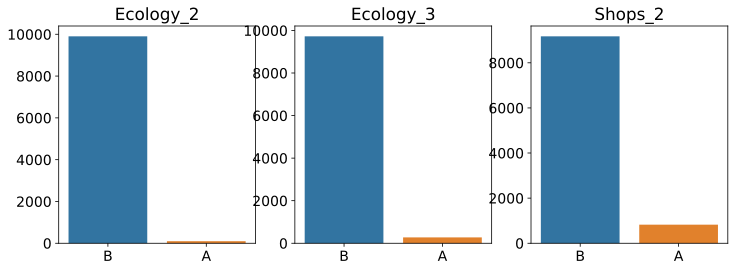

In [274]:
plt.figure(figsize = (12,4))

for i, colname in enumerate(obj_features):
    counts = train[colname].value_counts()
    
    plt.subplot(1,3,i+1)    
    plt.title(colname)
    sns.barplot(counts.index, counts.values)
    
plt.show()

In [275]:
for column in obj_features:
    print('{}\n'.format(train[column].value_counts()))

B    9903
A      97
Name: Ecology_2, dtype: int64

B    9725
A     275
Name: Ecology_3, dtype: int64

B    9175
A     825
Name: Shops_2, dtype: int64



In [276]:
Ecology_2_map = {
    "B": 1,
    "A": 0,
}

train["Ecology_2"] = train["Ecology_2"].map(Ecology_2_map)
test["Ecology_2"] = test["Ecology_2"].map(Ecology_2_map)

In [277]:
Ecology_3_map = {
    "B": 1,
    "A": 0,
}

train["Ecology_3"] = train["Ecology_3"].map(Ecology_3_map)
test["Ecology_3"] = test["Ecology_3"].map(Ecology_3_map)

In [278]:
Shops_2_map = {
    "B": 1,
    "A": 0,
}

train["Shops_2"] = train["Shops_2"].map(Shops_2_map)
test["Shops_2"] = test["Shops_2"].map(Shops_2_map)

Так как признаки принимают всего два значения, заменим их на бинарные признаки.

Признак Healthcare_1 содержит очень много пропущенных значений. Не будем учитывать этот признак в процессе анализа.

In [279]:
train.drop(['Healthcare_1'], axis=1, inplace=True)
test.drop(['Healthcare_1'], axis=1, inplace=True)

Исследуем значения признаков **LifeSquare и Square**. Попробуем установить зависимость между жилой площадью и полной площадью квартиры.

In [280]:
train.describe().transpose()

count           mean            std           min  \
Id             10000.0    8383.407700    4859.019020      0.000000   
DistrictId     10000.0      50.400800      43.587592      0.000000   
Rooms          10000.0       1.890500       0.839512      0.000000   
Square         10000.0      56.315775      21.058732      1.136859   
LifeSquare      7887.0      37.199645      86.241209      0.370619   
KitchenSquare  10000.0       6.273300      28.560917      0.000000   
Floor          10000.0       8.526700       5.241148      1.000000   
HouseFloor     10000.0      12.609400       6.775974      0.000000   
HouseYear      10000.0    3990.166300  200500.261427   1910.000000   
Ecology_1      10000.0       0.118858       0.119025      0.000000   
Ecology_2      10000.0       0.990300       0.098015      0.000000   
Ecology_3      10000.0       0.972500       0.163543      0.000000   
Social_1       10000.0      24.687000      17.532614      0.000000   
Social_2       10000.0    5352.157400    4006.799803    168.000000   
Social_3       10000.0       8.039200      23.831875      0.000000   
Helthcare_2    10000.0       1.319500       1.493601      0.000000   
Shops_1        10000.0       4.231300       4.806341      0.000000   
Shops_2        10000.0       0.917500       0.275139      0.000000   
Price          10000.0  214138.857399   92872.293865  59174.778028   

                         25%            50%            75%           max  
Id               4169.500000    8394.500000   12592.500000  1.679800e+04  
DistrictId         20.000000      36.000000      75.000000  2.090000e+02  
Rooms               1.000000       2.000000       2.000000  1.900000e+01  
Square             41.774881      52.513310      65.900625  6.410652e+02  
LifeSquare         22.769832      32.781260      45.128803  7.480592e+03  
KitchenSquare       1.000000       6.000000       9.000000  2.014000e+03  
Floor               4.000000       7.000000      12.000000  4.200000e+01  
HouseFloor          9.000000      13.000000      17.000000  1.170000e+02  
HouseYear        1974.000000    1977.000000    2001.000000  2.005201e+07  
Ecology_1           0.017647       0.075424       0.195781  5.218671e-01  
Ecology_2           1.000000       1.000000       1.000000  1.000000e+00  
Ecology_3           1.000000       1.000000       1.000000  1.000000e+00  
Social_1            6.000000      25.000000      36.000000  7.400000e+01  
Social_2         1564.000000    5285.000000    7227.000000  1.908300e+04  
Social_3            0.000000       2.000000       5.000000  1.410000e+02  
Helthcare_2         0.000000       1.000000       2.000000  6.000000e+00  
Shops_1             1.000000       3.000000       6.000000  2.300000e+01  
Shops_2             1.000000       1.000000       1.000000  1.000000e+00  
Price          153872.633942  192269.644879  249135.462171  6.332335e+05

In [281]:
# Функция для отображения scatter-графика по двум признакам.
def draw_scatter(column_x, column_y, df):
    plt.scatter(df[column_x], df[column_y])
    plt.xlabel(column_x)
    plt.ylabel(column_y)
    plt.show()  

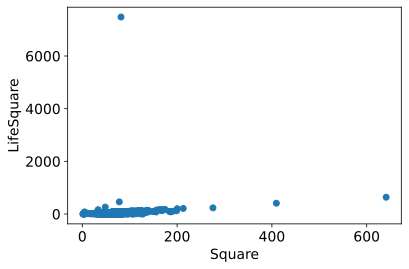

In [282]:
draw_scatter('Square', 'LifeSquare', train)

Оба признака имеют выбросы. Избавимся от них.

In [283]:
# Функция вырезает из выборки выбросы.
def drop_by_IQ(column, df):
    IQ=df[column].describe()['75%']-df[column].describe()['25%']
    low_border=df[column].describe()['25%']-IQ*1.5
    high_border=df[column].describe()['75%']+IQ*1.5
    
    print('For column {}\n\tIQ:\t{}\n\tLOW:\t{}\n\tHIGH:\t{}\n'.format(column, IQ, low_border, high_border))
    
    size_before = df[column].size
    df.drop(df[(df[column]<low_border)|(df[column]>high_border)].index, axis=0, inplace=True)    
    size_after = df[column].size
    
    lost_percentage = (size_before - size_after) * 100 / size_before 
    print('Lost {}% of data.'.format('%0.2f' % lost_percentage))

In [284]:
drop_by_IQ('Square', train)
drop_by_IQ('Square', test)
drop_by_IQ('LifeSquare', train)
drop_by_IQ('LifeSquare', test)

For column Square
	IQ:	24.125744426186976
	LOW:	5.586264180189367
	HIGH:	102.08924188493728

Lost 2.42% of data.
For column Square
	IQ:	24.37889829487171
	LOW:	5.337883253363636
	HIGH:	102.85347643285048

Lost 2.20% of data.
For column LifeSquare
	IQ:	21.756925644753355
	LOW:	-9.940131635100524
	HIGH:	77.08757094391291

Lost 1.91% of data.
For column LifeSquare
	IQ:	21.593453392655356
	LOW:	-9.340938098054458
	HIGH:	77.03287547256696

Lost 1.98% of data.


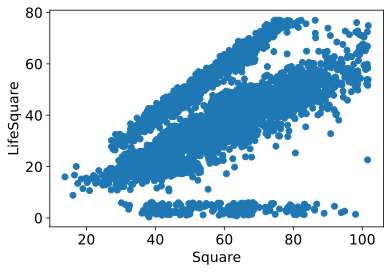

In [285]:
draw_scatter('Square', 'LifeSquare', train)

Найдём долю жилой площади от общей по сроедним значениям в выборке и заполним пропущенные значения в столбце LifeSquare.

In [286]:
# Функция заполняет пустые значения признака LifeSquare, высчитывая его через общую площадь квартиры.
def fill_life_square(df, coeff):
    df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['Square'] * coeff

In [287]:
square_mean_values = train[['Square', 'LifeSquare']].dropna().mean()
square_coeff = square_mean_values[1] / square_mean_values[0]
square_coeff

0.6378520569631749

In [288]:
fill_life_square(train, square_coeff)
fill_life_square(test, square_coeff)

Признак **KitchenSquare** содержит выбросы. Избавимся от них.

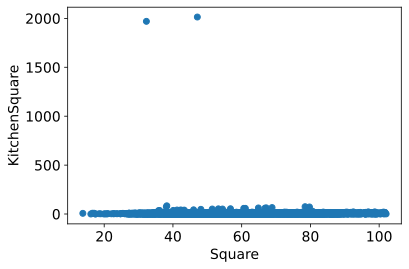

In [289]:
draw_scatter('Square', 'KitchenSquare', train)

In [290]:
# Функция заменяет выбросы в выборке на среднее значение по признаку.
def replace_by_IQ(column, df):
    IQ=df[column].describe()['75%']-df[column].describe()['25%']
    low_border=df[column].describe()['25%']-IQ*1.5
    high_border=df[column].describe()['75%']+IQ*1.5
    mean = df[column].mean()
    
    print('For column {}\n\tIQ:\t{}\n\tLOW:\t{}\n\tHIGH:\t{}\n\tMEAN:\t{}'.format(column, IQ, low_border, high_border, mean))

    index_to_replace = df[(df[column]<low_border)|(df[column]>high_border)].index

    df.loc[index_to_replace, column] = mean
    print('In {} row {} was replaced to {}.'.format(index_to_replace.size, column, mean))

In [291]:
replace_by_IQ('KitchenSquare', train)
replace_by_IQ('KitchenSquare', test)

For column KitchenSquare
	IQ:	8.0
	LOW:	-11.0
	HIGH:	21.0
	MEAN:	6.2431048892603425
In 31 row KitchenSquare was replaced to 6.2431048892603425.
For column KitchenSquare
	IQ:	8.0
	LOW:	-11.0
	HIGH:	21.0
	MEAN:	5.973503025245149
In 13 row KitchenSquare was replaced to 5.973503025245149.


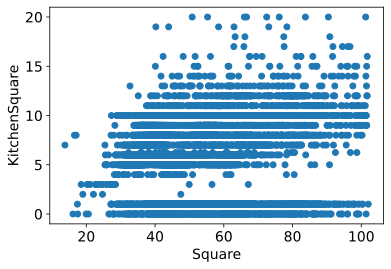

In [292]:
draw_scatter('Square', 'KitchenSquare', train)

Признак **HouseYear** так же содержит выпадающие значения. Обработаем их.

In [293]:
mean_year = np.round(train.loc[train['HouseYear'] <= 2020, 'HouseYear'].mean())
mean_year

1984.0

In [294]:
# Функция заменяет выбросы признака HouseYear средним значением.
def clean_year(df, mean_year):
    df.loc[df['HouseYear'] > 2020, 'HouseYear'] = mean_year

In [295]:
clean_year(test, mean_year)
clean_year(train, mean_year)

Приведем колонки **'Id' и 'DistrictId'** на строковые т.к. они не несут в себе математический характер

In [296]:
train['Id'] = train['Id'].astype(str)
train['DistrictId'] = train['DistrictId'].astype(str)
test['Id'] = test['Id'].astype(str)
test['DistrictId'] = test['DistrictId'].astype(str)

Заполним **Rooms**, где количество 0 модой

In [297]:
Rmode = train['Rooms'].mode()[0]
train.loc[train['Rooms']==0, 'Rooms'] = Rmode
test.loc[test['Rooms']==0, 'Rooms'] = Rmode


Ещё раз взглянем на получившийся датасет.

In [298]:
train.describe()

Rooms       Square   LifeSquare  KitchenSquare        Floor  \
count  9572.00000  9572.000000  9572.000000    9572.000000  9572.000000   
mean      1.84674    54.118859    34.519826       5.701163     8.471061   
std       0.80875    15.594497    13.030713       3.773149     5.168552   
min       1.00000    13.784865     0.370619       0.000000     1.000000   
25%       1.00000    41.537091    24.065821       1.000000     4.000000   
50%       2.00000    51.217517    32.871722       6.000000     7.000000   
75%       2.00000    64.293638    43.319537       9.000000    12.000000   
max      19.00000   102.032801    77.052978      20.000000    42.000000   

        HouseFloor    HouseYear    Ecology_1    Ecology_2    Ecology_3  \
count  9572.000000  9572.000000  9572.000000  9572.000000  9572.000000   
mean     12.586293  1984.285311     0.119942     0.989866     0.971584   
std       6.628252    18.135698     0.119592     0.100160     0.166167   
min       0.000000  1910.000000     0.000000     0.000000     0.000000   
25%       9.000000  1973.000000     0.017647     1.000000     1.000000   
50%      12.000000  1977.000000     0.075779     1.000000     1.000000   
75%      17.000000  1999.000000     0.195781     1.000000     1.000000   
max     117.000000  2020.000000     0.521867     1.000000     1.000000   

          Social_1      Social_2     Social_3  Helthcare_2      Shops_1  \
count  9572.000000   9572.000000  9572.000000  9572.000000  9572.000000   
mean     24.914333   5390.685959     8.029461     1.327518     4.237986   
std      17.488685   3994.347092    23.702448     1.485634     4.792616   
min       0.000000    168.000000     0.000000     0.000000     0.000000   
25%       6.000000   1564.000000     0.000000     0.000000     1.000000   
50%      25.000000   5285.000000     2.000000     1.000000     3.000000   
75%      36.000000   7287.000000     5.000000     2.000000     6.000000   
max      74.000000  19083.000000   141.000000     6.000000    23.000000   

           Shops_2          Price  
count  9572.000000    9572.000000  
mean      0.920184  209182.371820  
std       0.271022   87271.970772  
min       0.000000   59174.778028  
25%       1.000000  151904.418474  
50%       1.000000  189610.138453  
75%       1.000000  244221.524382  
max       1.000000  633233.466570

Выбросов нет. В процессе подготовки данных мы заменили категориальные признаки на бинарные. Исключили из анализа признак Healthcare_1. Исключили выбросы из выборки по признакам Square и LifeSquare. Заменили выбросы по признаку KitchenSquare на средние значения. Заполнили дома с количеством комнат 0 на моду, привели  колонки 'Id' и 'DistrictId' на строковые И заполнили пропущенные значения по признаку LifeSquare.

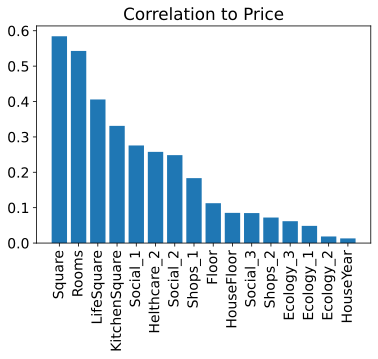

In [299]:
corrmat = train.loc[:, train.columns != 'Id'].corrwith(
    train['Price']).abs().sort_values(ascending=False)[1:]
plt.bar(corrmat.index, corrmat.values)
plt.title('Correlation to Price')
plt.xticks(rotation='vertical')
plt.show()

<AxesSubplot:>

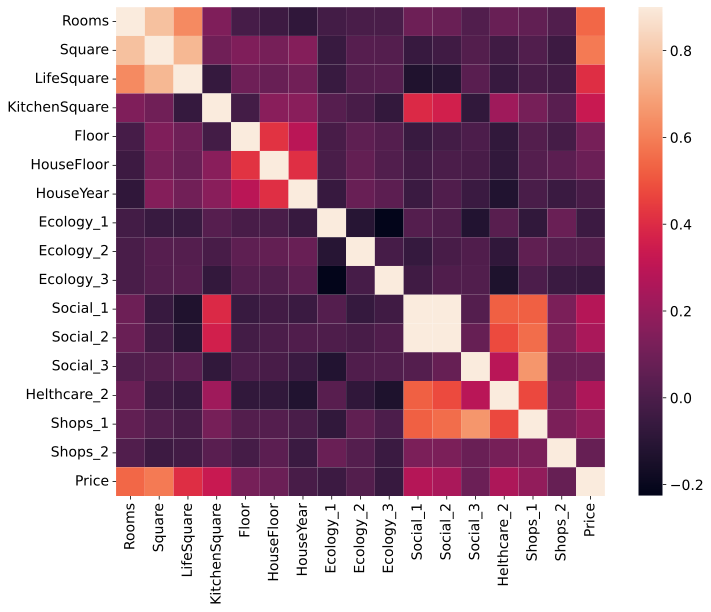

In [300]:
corrmat = train.loc[:, train.columns != 'Id'].corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=0.9, square=True)

Разобьем датасет train на тестовый и валидационный.

In [301]:
features = train.columns.drop('Id').drop('DistrictId').drop('Price')
target = 'Price'


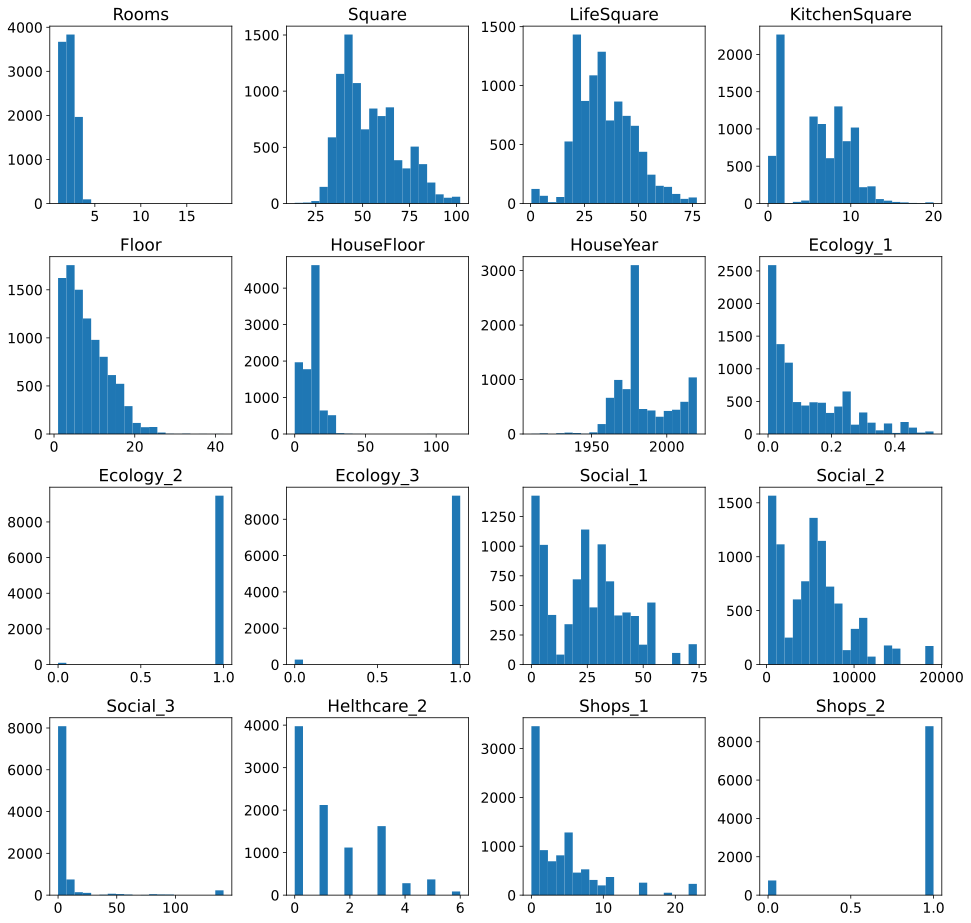

In [302]:
X = pd.DataFrame(train, columns=features)
y = pd.DataFrame(train, columns=[target])
X.hist(figsize=(16,16), bins=20, grid=False);

In [303]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [304]:
X_test = test[features]
X_test.head()

Rooms     Square  LifeSquare  KitchenSquare  Floor  HouseFloor  HouseYear  \
0    2.0  49.882643   33.432782            6.0      6        14.0       1972   
1    2.0  69.263183   44.179664            1.0      6         1.0       1977   
2    1.0  13.597819   15.948246           12.0      2         5.0       1909   
3    2.0  73.046609   51.940842            9.0     22        22.0       2007   
4    1.0  47.527111   43.387569            1.0     17        17.0       2017   

   Ecology_1  Ecology_2  Ecology_3  Social_1  Social_2  Social_3  Helthcare_2  \
0   0.310199          1          1        11      2748         1            0   
1   0.075779          1          1         6      1437         3            0   
2   0.000000          1          1        30      7538        87            5   
3   0.101872          1          1        23      4583         3            3   
4   0.072158          1          1         2       629         1            0   

   Shops_1  Shops_2  
0        0        1  
1        2        1  
2        5        1  
3        3        1  
4        0        0

Масштабируем данные.

In [305]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[features])
X_valid_scaled = scaler.transform(X_valid[features])
X_test_scaled = scaler.transform(X_test[features])

In [306]:
X_train_scaled 

array([[ 0.19166701, -0.72296728, -0.36312934, ..., -0.21425979,
        -0.88662999,  0.2978637 ],
       [-1.03251692, -1.33025957, -0.73700065, ...,  0.46448281,
        -0.88662999,  0.2978637 ],
       [ 0.19166701, -0.70136807, -0.45656896, ...,  0.46448281,
         0.15921877,  0.2978637 ],
       ...,
       [-1.03251692, -0.77875797, -0.58988297, ...,  1.14322541,
         3.92427428,  0.2978637 ],
       [-1.03251692, -0.50258078, -0.37940581, ..., -0.89300239,
        -0.25912074,  0.2978637 ],
       [ 0.19166701, -0.44832235, -0.13156475, ..., -0.89300239,
        -0.25912074,  0.2978637 ]])

### Выбор модели

**Функция для сравнения результатов моделей**

In [307]:
model_dict = {
   'lr': LinearRegression(),
#    'lasso': Lasso(random_state=42),
#    'ridge': Ridge(random_state=42),
#    'enet': ElasticNet(random_state=42),
   'knn': KNeighborsRegressor(),
   'dt': DecisionTreeRegressor(random_state=42),
   'rf': RandomForestRegressor(random_state=42),
    'gb': GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=10,
                                     random_state=42,  
                                     n_estimators=100)
}

score_list = []

for model in model_dict:
    model_dict[model].fit(X_train_scaled, y_train)
    y_pred_train = model_dict[model].predict(X_train_scaled)
    y_pred_valid = model_dict[model].predict(X_valid_scaled)
    score_train = r2(y_train, y_pred_train)
    score_valid = r2(y_valid, y_pred_valid)
    score_list.append((score_train, score_valid))

for model, scores in zip(model_dict.keys(), score_list):
    print(f'{model}: \n\ttrain: {np.round(scores[0], 4)} \n\tvalid: {np.round(scores[1], 4)}')


lr: 
	train: 0.5292 
	valid: 0.4929
knn: 
	train: 0.7564 
	valid: 0.6165
dt: 
	train: 1.0 
	valid: 0.4858
rf: 
	train: 0.962 
	valid: 0.7032
gb: 
	train: 0.8897 
	valid: 0.7081


Лучший результат "из коробки" показала модель GradientBoostingRegressor
baseline R^2 = 0.7081
продолжим работать с моделью GradientBoostingRegressor

In [308]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=10,
                                     random_state=42,  
                                     n_estimators=100)
gb_model.fit(X_train_scaled, y_train)


GradientBoostingRegressor(criterion='mse', max_depth=7, min_samples_leaf=10,
                          random_state=42)

In [311]:
# Функция считает метрику r2_score и mse по переданным наборам данных и модели.
def fit_pred(x_train, y_train, x_test, y_test, model):
    model.fit(x_train, y_train)
    
    y_train_pred = model.predict(x_train) 
    y_test_pred = model.predict(x_test)
    
    r2_train = r2(y_train, y_train_pred)
    mse_train = mse(y_train, y_train_pred)
    print(f'r2_train = {r2_train}, mse_train: {mse_train}')
    
    r2_test = r2(y_test, y_test_pred)
    mse_test = mse(y_test, y_test_pred)
    print(f'r2_test = {r2_test}, mse_test: {mse_test}')


In [310]:
fit_pred(X_train_scaled, y_train, X_valid_scaled, y_valid, gb_model)

r2_train = 0.889726737476932, mae_train: 839861988.1797737
r2_test = 0.7080782863853989, mae_test: 2222560474.9434423


Предсказываем цены для тестового датасета и выгружаем результат в файл.

In [312]:
price = gb_model.predict(X_test_scaled)
pd.DataFrame({ 'Id': test['Id'], 'Price': price }).to_csv('KAtaiarova_predictions.csv', index=False)
